# 과적합 해결

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [22]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [23]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [24]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치크기, h, w) -> (배치크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [25]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [26]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2750, Accuracy: 0.9193
Epoch 2 | Val Loss: 0.1998, Accuracy: 0.9401
Epoch 3 | Val Loss: 0.1683, Accuracy: 0.9497
Epoch 4 | Val Loss: 0.1425, Accuracy: 0.9566
Epoch 5 | Val Loss: 0.1317, Accuracy: 0.9613

배치 정규화 적용
Epoch 1 | Val Loss: 0.1322, Accuracy: 0.9597
Epoch 2 | Val Loss: 0.0965, Accuracy: 0.9719
Epoch 3 | Val Loss: 0.0929, Accuracy: 0.9712
Epoch 4 | Val Loss: 0.0853, Accuracy: 0.9719
Epoch 5 | Val Loss: 0.0911, Accuracy: 0.9722


In [27]:
for batch_size in [16, 32, 128]:
    print(f'batch size: {batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1256, Accuracy: 0.9632
Epoch 2 | Val Loss: 0.1069, Accuracy: 0.9675
Epoch 3 | Val Loss: 0.0894, Accuracy: 0.9722
Epoch 4 | Val Loss: 0.0923, Accuracy: 0.9712
Epoch 5 | Val Loss: 0.0890, Accuracy: 0.9722
batch size: 32
Epoch 1 | Val Loss: 0.1301, Accuracy: 0.9597
Epoch 2 | Val Loss: 0.0996, Accuracy: 0.9691
Epoch 3 | Val Loss: 0.0862, Accuracy: 0.9730
Epoch 4 | Val Loss: 0.0852, Accuracy: 0.9735
Epoch 5 | Val Loss: 0.0786, Accuracy: 0.9747
batch size: 128
Epoch 1 | Val Loss: 0.1432, Accuracy: 0.9576
Epoch 2 | Val Loss: 0.1118, Accuracy: 0.9656
Epoch 3 | Val Loss: 0.1072, Accuracy: 0.9669
Epoch 4 | Val Loss: 0.0870, Accuracy: 0.9728
Epoch 5 | Val Loss: 0.0869, Accuracy: 0.9731


### 드롭아웃 적용

In [28]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [29]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2764, Accuracy: 0.9166
Epoch 2 | Val Loss: 0.1912, Accuracy: 0.9419
Epoch 3 | Val Loss: 0.1602, Accuracy: 0.9514
Epoch 4 | Val Loss: 0.1701, Accuracy: 0.9498
Epoch 5 | Val Loss: 0.1410, Accuracy: 0.9569
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3535, Accuracy: 0.8964
Epoch 2 | Val Loss: 0.2737, Accuracy: 0.9213
Epoch 3 | Val Loss: 0.2507, Accuracy: 0.9269
Epoch 4 | Val Loss: 0.2306, Accuracy: 0.9334
Epoch 5 | Val Loss: 0.2375, Accuracy: 0.9311
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.2965, Accuracy: 0.7361
Epoch 2 | Val Loss: 1.2388, Accuracy: 0.6888
Epoch 3 | Val Loss: 1.2566, Accuracy: 0.7072
Epoch 4 | Val Loss: 1.2003, Accuracy: 0.6758
Epoch 5 | Val Loss: 1.1890, Accuracy: 0.6426


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [30]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [31]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)

Epoch 1 | Val Loss: 0.3812, Accuracy: 0.8868
Epoch 2 | Val Loss: 0.3161, Accuracy: 0.9089
Epoch 3 | Val Loss: 0.2630, Accuracy: 0.9261
Epoch 4 | Val Loss: 0.2485, Accuracy: 0.9265
Epoch 5 | Val Loss: 0.2447, Accuracy: 0.9287

Epoch 1 | Val Loss: 0.1311, Accuracy: 0.9595
Epoch 2 | Val Loss: 0.1224, Accuracy: 0.9632
Epoch 3 | Val Loss: 0.1142, Accuracy: 0.9666
Epoch 4 | Val Loss: 0.1072, Accuracy: 0.9682
Epoch 5 | Val Loss: 0.1018, Accuracy: 0.9695


### Learning Rate Schduler 적용

In [32]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}')


In [34]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

epoch 1 | Val Loss: 0.3440, Accuracy: 0.8970, LearningRate: 0.01
epoch 2 | Val Loss: 0.2730, Accuracy: 0.9237, LearningRate: 0.01
epoch 3 | Val Loss: 0.2309, Accuracy: 0.9353, LearningRate: 0.001
epoch 4 | Val Loss: 0.1673, Accuracy: 0.9517, LearningRate: 0.001
epoch 5 | Val Loss: 0.1599, Accuracy: 0.9533, LearningRate: 0.001
epoch 6 | Val Loss: 0.1646, Accuracy: 0.9517, LearningRate: 0.0001
epoch 7 | Val Loss: 0.1512, Accuracy: 0.9559, LearningRate: 0.0001
epoch 8 | Val Loss: 0.1508, Accuracy: 0.9553, LearningRate: 0.0001
epoch 9 | Val Loss: 0.1505, Accuracy: 0.9554, LearningRate: 1e-05
epoch 10 | Val Loss: 0.1503, Accuracy: 0.9557, LearningRate: 1e-05


### 조기 종료 적용

In [38]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch + 1}')
            break
        
    return train_losses, val_losses

In [40]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [41]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.2937, Accuracy: 0.9116
Epoch 2 | Loss: 0.2569, Accuracy: 0.9219
Epoch 3 | Loss: 0.2388, Accuracy: 0.9302
Epoch 4 | Loss: 0.2644, Accuracy: 0.9240
Epoch 5 | Loss: 0.2712, Accuracy: 0.9242
Epoch 6 | Loss: 0.2540, Accuracy: 0.9312
Epoch 7 | Loss: 0.3078, Accuracy: 0.9173
Epoch 8 | Loss: 0.2846, Accuracy: 0.9226
Epoch 9 | Loss: 0.2743, Accuracy: 0.9297
Epoch 10 | Loss: 0.2589, Accuracy: 0.9310
Epoch 11 | Loss: 0.2503, Accuracy: 0.9315
Epoch 12 | Loss: 0.2676, Accuracy: 0.9296
Epoch 13 | Loss: 0.2671, Accuracy: 0.9337
Epoch 14 | Loss: 0.2714, Accuracy: 0.9282
Epoch 15 | Loss: 0.2600, Accuracy: 0.9310
Epoch 16 | Loss: 0.2644, Accuracy: 0.9336
Epoch 17 | Loss: 0.2427, Accuracy: 0.9377
Epoch 18 | Loss: 0.2683, Accuracy: 0.9284
Epoch 19 | Loss: 0.2582, Accuracy: 0.9354
Epoch 20 | Loss: 0.2719, Accuracy: 0.9337
Epoch 21 | Loss: 0.3519, Accuracy: 0.9064
Epoch 22 | Loss: 0.2483, Accuracy: 0.9383
Epoch 23 | Loss: 0.2775, Accuracy: 0.9293
Epoch 24 | Loss: 0.2590, Accuracy: 0.9386
E

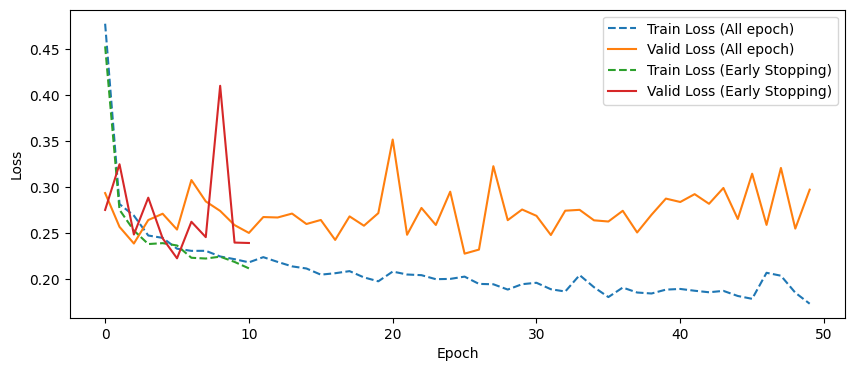

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L1, L2 적용

In [45]:
def train_reg(model, trian_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [46]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum= 0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum= 0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

epoch 1 | Train Loss: 0.4708, Val Loss: 0.2485, Accuracy: 0.9254
epoch 2 | Train Loss: 0.1932, Val Loss: 0.1726, Accuracy: 0.9492
epoch 3 | Train Loss: 0.1431, Val Loss: 0.1425, Accuracy: 0.9569
epoch 4 | Train Loss: 0.1175, Val Loss: 0.1288, Accuracy: 0.9603
epoch 5 | Train Loss: 0.0972, Val Loss: 0.1286, Accuracy: 0.9612
epoch 6 | Train Loss: 0.0856, Val Loss: 0.0997, Accuracy: 0.9698
epoch 7 | Train Loss: 0.0746, Val Loss: 0.0992, Accuracy: 0.9703
epoch 8 | Train Loss: 0.0667, Val Loss: 0.0946, Accuracy: 0.9710
epoch 9 | Train Loss: 0.0606, Val Loss: 0.1077, Accuracy: 0.9684
epoch 10 | Train Loss: 0.0527, Val Loss: 0.0915, Accuracy: 0.9713
epoch 1 | Train Loss: 0.5213, Val Loss: 0.3517, Accuracy: 0.8949
epoch 2 | Train Loss: 0.2794, Val Loss: 0.2599, Accuracy: 0.9252
epoch 3 | Train Loss: 0.2402, Val Loss: 0.2707, Accuracy: 0.9251
epoch 4 | Train Loss: 0.2215, Val Loss: 0.2259, Accuracy: 0.9377
epoch 5 | Train Loss: 0.2078, Val Loss: 0.2124, Accuracy: 0.9404
epoch 6 | Train Loss: 0.

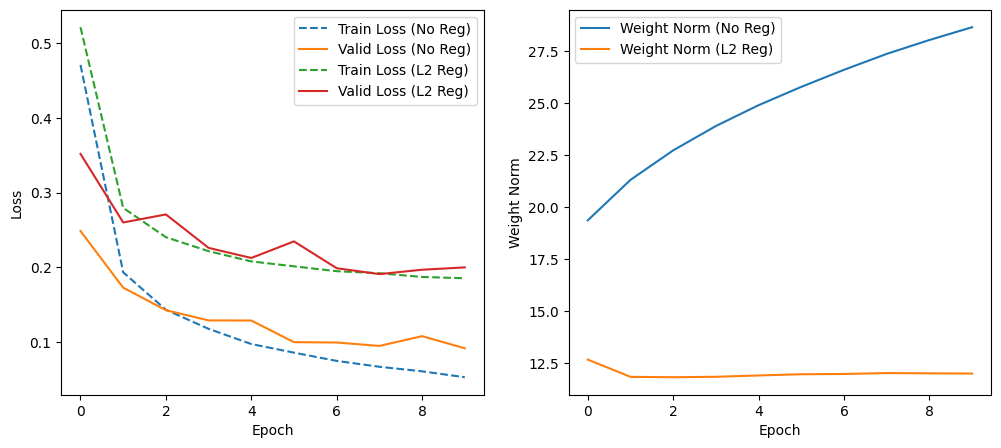

In [49]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()